### Importing the dependencies

In [1]:
# For data visualization and manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import re

print("Everything imported successfully😊")

Everything imported successfully😊


### Dataset desciption
- VoLTE stands for Voice over LTE. It is a technology that allows you to make and receive calls over the LTE network. This means that you can enjoy better call quality and voice clarity, even when you are in a poor cellular reception area.- 
Wi-Fi is a wireless networking technology that allows you to connect to the internet without using a cellular network. This is a great way to save on your data plan, especially if you are using a lot of data for streaming videos or music
  .- 
IR Blaster is a small infrared transmitter that is built into some smartphones. It allows you to use your phone as a remote control for other devices, such as your TV, air conditioner, or stere
- NFC stands for Near Field Communication. It is a short-range wireless technology that allows two devices to communicate with each other when they are brought within close proximity. The maximum distance for NFC communication is about 4 inches.o.

In [2]:
# Loading the data from csv file to dataframe
df = pd.read_csv('Data.csv')

### Exploratory data analysis

In [3]:
# Checking shape of the dataframe
print("Shape of the dataframe : ",df.shape)

Shape of the dataframe :  (1020, 11)


In [4]:
# Checking any 3 random rows of the dataframe
df.sample(3)

,model,price,rating,sim,processor,ram,battery,display,camera,card,os
687,Samsung Galaxy A04s (4GB RAM + 128GB),"₹14,499",72.0,"Dual Sim, 3G, 4G, VoLTE, Wi-Fi","Exynos 850, Octa Core, 2 GHz Processor","4 GB RAM, 128 GB inbuilt",5000 mAh Battery with 15W Fast Charging,"6.5 inches, 720 x 1600 px, 90 Hz Display with ...",50 MP + 2 MP + 2 MP Triple Rear & 5 MP Front C...,"Memory Card Supported, upto 1 TB",Android v12
72,iQOO Z6 Lite 5G,"₹13,989",75.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 4 Gen 1, Octa Core, 2 GHz Processor","4 GB RAM, 64 GB inbuilt",5000 mAh Battery with 18W Fast Charging,"6.58 inches, 1080 x 2408 px, 120 Hz Display wi...",50 MP + 2 MP Dual Rear & 8 MP Front Camera,"Memory Card (Hybrid), upto 1 TB",Android v12
793,Oppo A15s (4GB RAM + 128GB),"₹11,490",72.0,"Dual Sim, 3G, 4G, VoLTE, Wi-Fi","Helio P35 , Octa Core, 2.3 GHz Processor","4 GB RAM, 128 GB inbuilt",4230 mAh Battery,"6.52 inches, 720 x 1600 px Display with Water ...",13 MP + 2 MP + 2 MP Triple Rear & 8 MP Front C...,"Memory Card Supported, upto 256 GB",Android v10


In [5]:
# Let's take a look at the informatoin related to columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   model      1020 non-null   object 
 1   price      1020 non-null   object 
 2   rating     879 non-null    float64
 3   sim        1020 non-null   object 
 4   processor  1020 non-null   object 
 5   ram        1020 non-null   object 
 6   battery    1020 non-null   object 
 7   display    1020 non-null   object 
 8   camera     1019 non-null   object 
 9   card       1013 non-null   object 
 10  os         1003 non-null   object 
dtypes: float64(1), object(10)
memory usage: 87.8+ KB


model         0.000000
price         0.000000
rating       13.823529
sim           0.000000
processor     0.000000
ram           0.000000
battery       0.000000
display       0.000000
camera        0.098039
card          0.686275
os            1.666667
dtype: float64


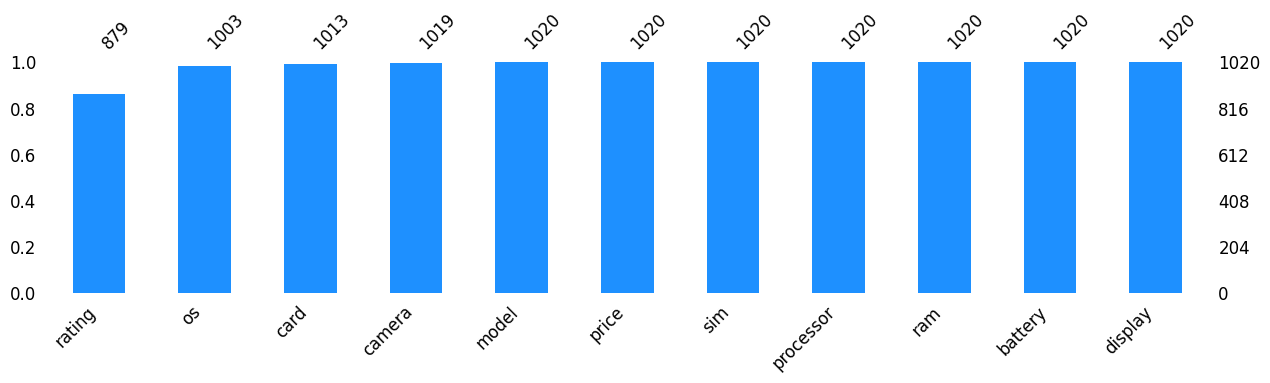

In [6]:
# Checking any missing values
print(df.isnull().mean()*100)

# Visualize missing values using a bar chart
msno.bar(df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [7]:
# Let's check if there are any duplicate valeus
print("Duplicate values :",df.duplicated().sum())

Duplicate values : 0


### Data procesing

- `price`: Remove rupee and , character
- `sim`: Extracting a binary feature (called sim type 0 : Single sim and 1 : Dual sim)
- `sim`: Extracting a binary feature called (Has_5g)

In [8]:
# Removing rupee and , character from the 'price' feature and converting to int
for index in range(len(df)):
    item = df.loc[index, 'price']
    item = item.replace("₹", "").replace(",", "")
    item = re.sub(r'[^\d]', '', item)  # Remove any non-digit characters
    df.loc[index, 'price'] = item

df['price'] = df['price'].astype(np.int64)

In [9]:
# Creation of new feature called sim type 
Sim_type = []
for item in df['sim']:
    sim_type = item.split(',')[0]
    if sim_type == 'Dual Sim':
        Sim_type.append(1)
    else:
        Sim_type.append(0)

df['Sim_type'] = pd.Series(Sim_type)

In [14]:
# Creation of new feature called Has_5g 
Has_5g = []
for item in df['sim']:
    sim_info = item.split(',')
    if ' 5G' in sim_info:
        Has_5g.append(1)
    else:
        Has_5g.append(0)

df['Has_5g'] = pd.Series(Has_5g)

In [13]:
list = df['sim'].iloc[0].split(',')
if ' 5G' in list:
    print("Yes")

Yes


In [15]:
df.head(2)

,model,price,rating,sim,processor,ram,battery,display,camera,card,os,Sim_type,Has_5g
0,OnePlus 11 5G,54999,89.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2 GHz Processor","12 GB RAM, 256 GB inbuilt",5000 mAh Battery with 100W Fast Charging,"6.7 inches, 1440 x 3216 px, 120 Hz Display wit...",50 MP + 48 MP + 32 MP Triple Rear & 16 MP Fron...,Memory Card Not Supported,Android v13,1,1
1,OnePlus Nord CE 2 Lite 5G,19989,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 33W Fast Charging,"6.59 inches, 1080 x 2412 px, 120 Hz Display wi...",64 MP + 2 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12,1,1


<Axes: xlabel='price'>

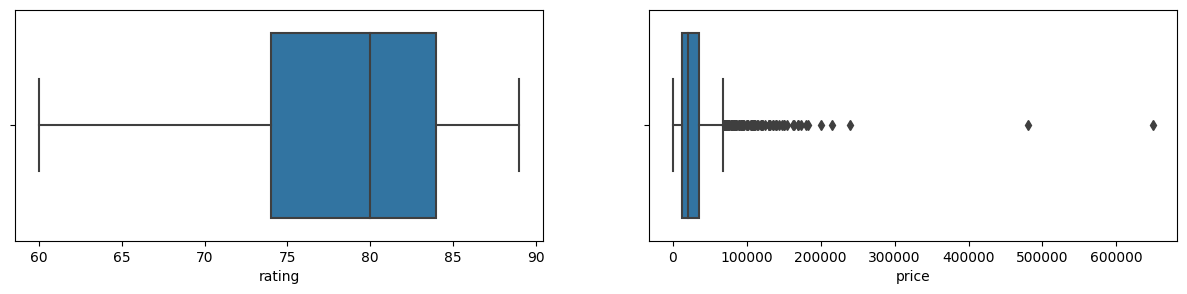

In [13]:
# Let's see if there are any outliers in the rating and price feature
fig,ax = plt.subplots(1,2,figsize = (15,3))

sns.boxplot(x = df['rating'],ax = ax[0])
sns.boxplot(x = df['price'],ax = ax[1])